# 05 - Advanced Graph Analysis

Este notebook calcula métricas avançadas da rede, incluindo:
- propriedades globais do grafo;
- propriedades da maior componente conexa (LCC);
- distribuição de graus;
- centralidades na LCC (com cache para evitar recálculo pesado);
- resumo final salvo em CSV.


In [15]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import torch

plt.style.use("default")

# Caminhos ABSOLUTOS para o ambiente atual
DATA_PATH = Path("/workspace/data/collaboration.edgelist.txt")
EMBEDDINGS_PATH = Path("/workspace/results/node_embeddings.pt")

DATA_DIR = DATA_PATH.parent
PROJECT_DIR = DATA_DIR.parent
RESULTS_DIR = PROJECT_DIR / "results"
FIG_DIR = RESULTS_DIR / "figures"

RESULTS_DIR.mkdir(exist_ok=True, parents=True)
FIG_DIR.mkdir(exist_ok=True, parents=True)

print("PROJECT_DIR:", PROJECT_DIR)
print("DATA_DIR:", DATA_DIR)
print("RESULTS_DIR:", RESULTS_DIR)
print("FIG_DIR:", FIG_DIR)
print("EDGELIST_PATH:", DATA_PATH, "| exists=", DATA_PATH.exists())

PROJECT_DIR: /workspace
DATA_DIR: /workspace/data
RESULTS_DIR: /workspace/results
FIG_DIR: /workspace/results/figures
EDGELIST_PATH: /workspace/data/collaboration.edgelist.txt | exists= True


## 1. Carregar o grafo

Carrega a lista de arestas e constrói um grafo não direcionado.

In [16]:
def load_graph(path: Path) -> nx.Graph:
    df_edges = pd.read_csv(
        path,
        sep=r"\s+",      # substitui delim_whitespace=True
        header=None,
        usecols=[0, 1],
        names=['source', 'target'],
    )
    G = nx.Graph()
    G.add_edges_from(zip(df_edges['source'], df_edges['target']))
    return G

G = load_graph(DATA_PATH)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Is connected:", nx.is_connected(G))

Number of nodes: 23133
Number of edges: 93439
Is connected: False


## 2. Métricas globais e da LCC

Calcula densidade, número de componentes, maior componente conexa e estatísticas básicas da LCC.

In [17]:
density = nx.density(G)
num_components = nx.number_connected_components(G)

components = sorted(nx.connected_components(G), key=len, reverse=True)
lcc_nodes = components[0]
LCC = G.subgraph(lcc_nodes).copy()

frac_lcc = len(lcc_nodes) / G.number_of_nodes()

print('Graph density:', density)
print('Number of components:', num_components)
print('LCC size (nodes):', len(lcc_nodes))
print('LCC fraction of nodes:', frac_lcc)

lcc_avg_degree = np.mean([d for _, d in LCC.degree()])
lcc_density = nx.density(LCC)
lcc_avg_clustering = nx.average_clustering(LCC)

print('LCC average degree:', lcc_avg_degree)
print('LCC density:', lcc_density)
print('LCC average clustering:', lcc_avg_clustering)

Graph density: 0.00034923119987489135
Number of components: 567
LCC size (nodes): 21363
LCC fraction of nodes: 0.9234859291920633
LCC average degree: 8.546177971258718
LCC density: 0.0004000645057231869
LCC average clustering: 0.6417316374785165


## 3. Distribuição de graus

Salva a distribuição de graus em CSV e plota um histograma simples.

Saved degree distribution to: /workspace/results/05_degree_distribution.csv


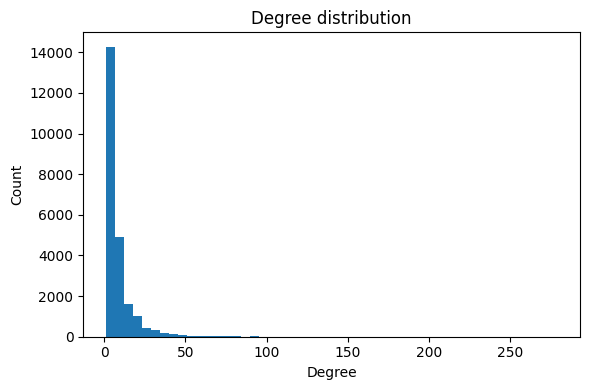

In [18]:
degrees = [d for _, d in G.degree()]
df_deg = pd.DataFrame({'degree': degrees})
deg_csv_path = RESULTS_DIR / '05_degree_distribution.csv'
df_deg.to_csv(deg_csv_path, index=False)
print('Saved degree distribution to:', deg_csv_path)

plt.figure(figsize=(6, 4))
plt.hist(degrees, bins=50)
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree distribution')
plt.tight_layout()
plt.show()

## 4. Centralidades na LCC (com cache)

Se o arquivo de centralidades já existir, ele é carregado.
Caso contrário, as centralidades são calculadas e salvas em CSV.


In [19]:
cent_path = RESULTS_DIR / '05_centralities_lcc.csv'

if cent_path.exists():
    print('✔ Centralities already exist — loading:', cent_path)
    df_cent = pd.read_csv(cent_path)
else:
    print('⚠ Computing centralities on the LCC — this is slow but runs only once.')

    deg_cent = nx.degree_centrality(LCC)
    clo_cent = nx.closeness_centrality(LCC)

    n_lcc = LCC.number_of_nodes()
    k_sample = min(200, n_lcc)
    bet_cent = nx.betweenness_centrality(LCC, k=k_sample, seed=42)

    df_cent = pd.DataFrame({
        'node': list(LCC.nodes()),
        'deg_cent': [deg_cent[n] for n in LCC.nodes()],
        'clo_cent': [clo_cent[n] for n in LCC.nodes()],
        'bet_cent': [bet_cent[n] for n in LCC.nodes()],
    })

    df_cent.to_csv(cent_path, index=False)
    print('✔ Saved centralities to:', cent_path)

print('Preview of LCC centralities:')
display(df_cent.head())

✔ Centralities already exist — loading: /workspace/results/05_centralities_lcc.csv
Preview of LCC centralities:


,node,deg_cent,clo_cent,bet_cent
0,0,0.000140,0.169169,0.000000
1,1680,0.000374,0.203609,0.000223
2,6918,0.000234,0.187202,0.000006
3,19642,0.000234,0.187202,0.000006
4,1,0.000374,0.205704,0.000000


## 5. Resumo final das métricas

Gera um resumo agregado das métricas globais e da LCC e salva em CSV.


In [20]:
summary = {
    'num_nodes': G.number_of_nodes(),
    'num_edges': G.number_of_edges(),
    'density': density,
    'num_components': num_components,
    'lcc_size': len(lcc_nodes),
    'lcc_fraction': frac_lcc,
    'lcc_num_edges': LCC.number_of_edges(),
    'lcc_density': lcc_density,
    'lcc_avg_degree': float(lcc_avg_degree),
    'lcc_avg_clustering': float(lcc_avg_clustering)
}

df_summary = pd.DataFrame([summary])
summary_path = RESULTS_DIR / '05_graph_summary.csv'
df_summary.to_csv(summary_path, index=False)
print('Saved graph summary to:', summary_path)
display(df_summary)

Saved graph summary to: /workspace/results/05_graph_summary.csv


,num_nodes,num_edges,density,num_components,lcc_size,lcc_fraction,lcc_num_edges,lcc_density,lcc_avg_degree,lcc_avg_clustering
0,23133,93439,0.000349,567,21363,0.923486,91286,0.0004,8.546178,0.641732


In [21]:
print('Notebook 05 finished successfully. 🚀')

Notebook 05 finished successfully. 🚀
